# Autoencoder Latent Feature Representation

Idea: Train an Autoencoder network to generate a latent feature representation
for the heartbeats, then use this representation with a classifier.

In [42]:
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.models import Model

In [2]:
def load_data(dataset):

     if dataset == 'mitbih':
         df_train = pd.read_csv("../data/mitbih_train.csv", header=None)
         df_train = df_train.sample(frac=1)
         df_test = pd.read_csv("../data/mitbih_test.csv", header=None)

         Y = np.array(df_train[187].values).astype(np.int8)
         X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

         Y_test = np.array(df_test[187].values).astype(np.int8)
         X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

         return X,Y,X_test,Y_test

     elif dataset == 'ptbdb':
         df_1 = pd.read_csv("../data/ptbdb_normal.csv", header=None)
         df_2 = pd.read_csv("../data/ptbdb_abnormal.csv", header=None)
         df = pd.concat([df_1, df_2])

         df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


         Y = np.array(df_train[187].values).astype(np.int8)
         X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

         Y_test = np.array(df_test[187].values).astype(np.int8)
         X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

         return X,Y,X_test,Y_test

     else:
         raise NotImplementedError('wrong dataset name')

In [3]:
X_train, y_train, X_test, y_test = load_data('mitbih')

## Representation Learning

In [60]:
def pad_signals(signals: np.ndarray, target_length: int) -> np.ndarray:
    return np.pad(signals, [(0,0), (0, target_length - signals.shape[1]), (0,0)])

class Autoencoder(Model):
    def __init__(self, input_shape: Tuple[int, int], latent_dim: int):
        super(Autoencoder, self).__init__()

        ## Encoder ##
        conv = layers.Conv1D(filters=5, kernel_size=3, strides=2, padding='same', input_shape=input_shape)
        max_pool = layers.MaxPool1D(pool_size=2, padding='same')
        conv2 = layers.Conv1D(filters=15, kernel_size=3, strides=2, padding='same')
        max_pool2 = layers.MaxPool1D(pool_size=2, padding='same')
        conv3 = layers.Conv1D(filters=30, kernel_size=3, strides=2, padding='same')
        max_pool3 = layers.MaxPool1D(pool_size=2, padding='same')
        flatten = layers.Flatten()
        dense = layers.Dense(latent_dim)

        self.encoder = tf.keras.Sequential([
            conv,
            layers.PReLU(),
            #layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            max_pool,
            conv2,
            layers.PReLU(),
            #layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            max_pool2,
            conv3,
            layers.PReLU(),
            #layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            max_pool3,
            flatten,
            dense,
            layers.Dropout(rate=0.1),
        ])

        ## Decoder ##
        dec_dense = layers.Dense(90, input_shape=(latent_dim,))
        reshape = layers.Reshape((3, 30))
        convt3 = layers.Conv1DTranspose(filters=30, kernel_size=3, strides=2, padding='same')
        upsample3 = layers.UpSampling1D(size=2)
        convt2 = layers.Conv1DTranspose(filters=15, kernel_size=3, strides=2, padding='same')
        upsample2 = layers.UpSampling1D(size=2)
        convt = layers.Conv1DTranspose(filters=5, kernel_size=3, strides=2, padding='same')
        upsample = layers.UpSampling1D(size=2)
        convt_final = layers.Conv1DTranspose(filters=1, kernel_size=3, strides=1, padding='same')

        self.decoder = tf.keras.Sequential([
            dec_dense,
            layers.PReLU(),
            layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            reshape,
            convt3,
            layers.PReLU(),
            #layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            upsample3,
            convt2,
            layers.PReLU(),
            #layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            upsample2,
            convt,
            layers.PReLU(),
            #layers.Dropout(rate=0.1),
            layers.BatchNormalization(),
            upsample,
            convt_final
        ])

    def encode(self, x):
        return self.encoder(x)

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [61]:
# Pad the signals to a large enough multiple of 2 so that there is no loss
# in dimensionality through the autoencoder.
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,
    random_state=42
)

X_valid_padded = pad_signals(X_valid_split, 192)
X_train_padded = pad_signals(X_train_split, 192)

autoencoder = Autoencoder(input_shape=X_train_padded.shape[1:], latent_dim=30)

In [62]:
#lr_schedule = schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=10000,
#    decay_rate=0.9
#)

autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    #optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss=losses.MeanSquaredError()
)

autoencoder.fit(
    X_train_padded,
    X_train_padded,
    batch_size=128,
    epochs=20,
    validation_data=(X_valid_padded, X_valid_padded)
)
autoencoder.save_weights('./checkpoints/autoencoder')

Epoch 1/20
548/548 [==============================] - 47s 65ms/step - loss: 0.0229 - val_loss: 0.0087
Epoch 2/20
548/548 [==============================] - 33s 61ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 3/20
548/548 [==============================] - 32s 59ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 4/20
548/548 [==============================] - 34s 62ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 5/20
548/548 [==============================] - 32s 58ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 6/20
548/548 [==============================] - 34s 61ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 7/20
548/548 [==============================] - 33s 61ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 8/20
548/548 [==============================] - 33s 60ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 9/20
548/548 [==============================] - 32s 59ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 10/20
548/548 [==============================] - 31s 57ms/step - loss: 0.004

Signal shape: (1, 192, 1)
Encoded signal shape: (1, 30)
Reconstructed signal shape: (1, 192, 1)


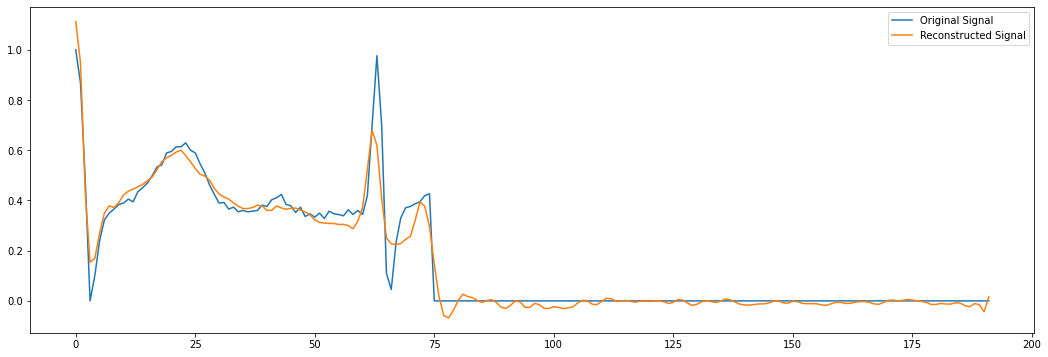

In [64]:
autoencoder = Autoencoder(input_shape=X_train_padded.shape[1:], latent_dim=30)
autoencoder.load_weights('./checkpoints/autoencoder')

signal = X_train_padded[20][tf.newaxis, ...]
print(f'Signal shape: {signal.shape}')

encoded_signal = autoencoder.encode(signal)
print(f'Encoded signal shape: {encoded_signal.shape}')

reconstructed_signal = autoencoder(signal)
print(f'Reconstructed signal shape: {reconstructed_signal.shape}')

fig, ax = plt.subplots(1, 1, figsize=(18,6))

ax.plot(tf.squeeze(signal, axis=0), label='Original Signal')
ax.plot(tf.squeeze(reconstructed_signal, axis=0), label='Reconstructed Signal')
ax.legend()

plt.show()

## Classification

Preliminary accuracy result on `mitbih` dataset:

| Latent Rep. | Classifier | Accuracy |
|---|---|---|
| Autoencoder (30D) | SVM (no fine-tune) | 0.9731026212095254 |
| Autoencoder (45D) | SVM (no fine-tune) | 0.9703614870652733 |
| Autoencoder (45D, OLD) | GBC (no fine-tune) | 0.9479755582205471 |

In [65]:
X_train_transformed = autoencoder.encode(X_train_padded)
X_valid_transformed = autoencoder.encode(X_valid_padded)

svm = SVC(verbose=True)

svm.fit(X_train_transformed, y_train_split)

[LibSVM]

SVC(verbose=True)

In [66]:
svm.score(X_valid_transformed, y_valid_split)

0.9731026212095254

In [ ]:
X_train_transformed = autoencoder.encode(X_train_padded)
X_valid_transformed = autoencoder.encode(X_valid_padded)

gbc = GradientBoostingClassifier(verbose=2)

gbc.fit(X_train_transformed, y_train_split)

In [ ]:
gbc.score(X_valid_transformed, y_valid_split)